# Instalamos librerias necesarias

Antes que nada, carguemos el entorno de trabajo


In [ ]:
%pip install --upgrade pip setuptools wheel --break-system-packages

In [ ]:
%pip install seaborn==0.13.1 numpy==1.26.4 matplotlib==3.7.1 pandas==2.1.4 lightgbm==4.4.0 optuna==3.6 scikit-learn==1.3.1 --break-system-packages





In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

/home/fernandomrestelli/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/fernandomrestelli/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cargamos el Dataset de Competencia_03 y defino la ganancia

Además de las semillas

In [2]:
base_path = '/home/fernandomrestelli/dmeyf2024/Competencia02y03/'
dataset_path = base_path + 'datos/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_03_reduced.csv'

ganancia_acierto = 273000
costo_estimulo = 7000



# agregue sus semillas
semillas = [945787,945799,945809,945811,945817]

data = pd.read_csv(dataset_path + dataset_file)

# Defino que meses para el train y test: 
Train: 1 año antes.
Test: Septiembre 2021.

In [3]:
# Define el rango de meses

mes_inicio = 202008
mes_fin = 202106


mes_test = 202107

Septiembre = 202109

# Feature Enginering

### Calculo deltas para usar data historica en la predicción

Ordeno el dataset por nro. de Cliente y foto mes (Secuencial), Selecciono las columnas numericas y calculo los deltas para las columnas numericas. Es decir la diferencia entre un mes y el anterior para un cliente en una columna particular. 

In [4]:
import pandas as pd

# Asegúrate de que el DataFrame `data` ya esté cargado

# Lista de columnas específicas donde calcular lags y deltas
columnas_especificas = [
    'mcuentas_saldo', 'mrentabilidad_annual', 'mactivos_margen', 'cliente_edad',
    'foto_mes', 'Master_fechaalta', 'Visa_fechaalta', 'Visa_mfinanciacion_limite',
    'cliente_antiguedad', 'mcaja_ahorro', 'ctrx_quarter', 'mcuenta_corriente',
    'Visa_Fvencimiento', 'Master_Fvencimiento', 'mcomisiones', 'numero_de_cliente',
    'chomebanking_transacciones', 'Visa_mpagominimo', 'Master_mlimitecompra',
    'Visa_msaldopesos', 'mpasivos_margen', 'mrentabilidad', 'cproductos',
    'mcomisiones_otras', 'ctarjeta_visa_transacciones', 'mcuenta_debitos_automaticos',
    'mcomisiones_mantenimiento', 'mtarjeta_visa_consumo', 'mtransferencias_recibidas',
    'Visa_mlimitecompra', 'Master_mfinanciacion_limite', 'Visa_msaldototal',
    'mcaja_ahorro_dolares', 'Visa_cconsumos', 'Visa_mpagospesos', 'Visa_mconsumototal',
    'mpayroll', 'thomebanking', 'ccomisiones_otras', 'ccallcenter_transacciones',
    'Master_fultimo_cierre', 'Master_msaldopesos', 'Master_msaldototal',
    'mttarjeta_visa_debitos_automaticos', 'ccomisiones_mantenimiento',
    'mtransferencias_emitidas', 'Visa_mconsumospesos', 'ctarjeta_debito_transacciones',
    'ccaja_ahorro', 'internet', 'mautoservicio', 'ctransferencias_recibidas',
    'mpagomiscuentas', 'Visa_mconsumosdolares', 'ctarjeta_debito',
    'ctransferencias_emitidas', 'Master_mpagominimo', 'cpayroll_trx',
    'mplazo_fijo_dolares', 'ccaja_seguridad', 'Visa_fultimo_cierre',
    'ctarjeta_visa_debitos_automaticos', 'mtarjeta_master_consumo'
]

# Ordenar los datos por cliente y por foto_mes para cálculos secuenciales
data = data.sort_values(by=['numero_de_cliente', 'foto_mes'])

# Crear un nuevo DataFrame para almacenar los lags y deltas
lags_deltas = pd.DataFrame(index=data.index)

# Calcular lags y deltas solo para las columnas específicas
for columna in columnas_especificas:
    if columna in data.columns:  # Verificar que la columna existe en el DataFrame
        # Lags
        lags_deltas[f'lag_1_{columna}'] = data.groupby('numero_de_cliente')[columna].shift(1)
        lags_deltas[f'lag_2_{columna}'] = data.groupby('numero_de_cliente')[columna].shift(2)

        # Deltas
        lags_deltas[f'delta_1_{columna}'] = data[columna] - lags_deltas[f'lag_1_{columna}']
        lags_deltas[f'delta_2_{columna}'] = data[columna] - lags_deltas[f'lag_2_{columna}']

# Concatenar los lags y deltas al DataFrame original
data = pd.concat([data, lags_deltas], axis=1)

# Visualizar las primeras filas del DataFrame
print(data.head())


/tmp/ipykernel_2453/3121938480.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lags_deltas[f'lag_1_{columna}'] = data.groupby('numero_de_cliente')[columna].shift(1)
/tmp/ipykernel_2453/3121938480.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lags_deltas[f'lag_2_{columna}'] = data.groupby('numero_de_cliente')[columna].shift(2)
/tmp/ipykernel_2453/3121938480.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

         numero_de_cliente  foto_mes  active_quarter  cliente_vip  internet  \
1924370          249221109    202008               1            0         1   
1924371          249221109    202009               1            0         1   
1924372          249221109    202010               1            0         0   
1924373          249221109    202011               1            0         0   
1924374          249221109    202012               1            0         0   

         cliente_edad  cliente_antiguedad  mrentabilidad  \
1924370            61                 295        3445.51   
1924371            61                 296        4207.19   
1924372            61                 297        1058.70   
1924373            61                 298         915.23   
1924374            61                 299        1981.43   

         mrentabilidad_annual  mcomisiones  ...  delta_1_Visa_fultimo_cierre  \
1924370              16305.23       965.43  ...                          NaN   
1924

### Calculo Tendencias



In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm  # Biblioteca para la barra de progreso

# Lista de columnas específicas donde calcular la tendencia
columnas_especificas = [
    'mcuentas_saldo', 'mrentabilidad_annual', 'mactivos_margen', 'cliente_edad',
    'Master_fechaalta', 'Visa_fechaalta', 'Visa_mfinanciacion_limite',
    'cliente_antiguedad', 'mcaja_ahorro', 'ctrx_quarter', 'mcuenta_corriente',
    'Visa_Fvencimiento', 'Master_Fvencimiento', 'mcomisiones', 'chomebanking_transacciones',
    'Visa_mpagominimo', 'Master_mlimitecompra', 'Visa_msaldopesos', 'mpasivos_margen',
    'mrentabilidad', 'cproductos', 'mcomisiones_otras', 'ctarjeta_visa_transacciones',
    'mcuenta_debitos_automaticos', 'mcomisiones_mantenimiento', 'mtarjeta_visa_consumo',
    'mtransferencias_recibidas', 'Visa_mlimitecompra', 'Master_mfinanciacion_limite',
    'Visa_msaldototal', 'mcaja_ahorro_dolares', 'Visa_cconsumos', 'Visa_mpagospesos',
    'Visa_mconsumototal', 'mpayroll', 'thomebanking', 'ccomisiones_otras',
    'ccallcenter_transacciones', 'Master_fultimo_cierre', 'Master_msaldopesos',
    'Master_msaldototal', 'mttarjeta_visa_debitos_automaticos', 'ccomisiones_mantenimiento',
    'mtransferencias_emitidas', 'Visa_mconsumospesos', 'ctarjeta_debito_transacciones',
    'ccaja_ahorro', 'internet', 'mautoservicio', 'ctransferencias_recibidas',
    'mpagomiscuentas', 'Visa_mconsumosdolares', 'ctarjeta_debito', 'ctransferencias_emitidas',
    'Master_mpagominimo', 'cpayroll_trx', 'mplazo_fijo_dolares', 'ccaja_seguridad',
    'Visa_fultimo_cierre', 'ctarjeta_visa_debitos_automaticos', 'mtarjeta_master_consumo'
]

# Asegurar que los datos estén ordenados por cliente y foto_mes
data = data.sort_values(by=['numero_de_cliente', 'foto_mes'])

# Ventana para cálculos históricos
ventana = 3

# Función para calcular la tendencia
def calcular_tendencia(subgrupo):
    if len(subgrupo) < 2:  # Si no hay suficientes datos
        return np.nan
    y = subgrupo  # Valores de la columna ya son arrays de NumPy
    x = np.arange(len(y))  # Índices representando el tiempo (ordenados por foto_mes)
    A = np.vstack([x, np.ones(len(x))]).T
    m, _ = np.linalg.lstsq(A, y, rcond=None)[0]  # Calcula la pendiente (tendencia)
    return m

# Diccionario para almacenar las tendencias calculadas
resultados_tendencias = {}

# Barra de progreso para el cálculo de tendencias
for columna in tqdm(columnas_especificas, desc="Calculando tendencias"):
    if columna in data.columns:  # Verificar que la columna existe
        resultados_tendencias[f'trend_{ventana}_{columna}'] = (
            data.groupby('numero_de_cliente')[columna]
            .rolling(window=ventana, min_periods=2)  # Ventana definida
            .apply(calcular_tendencia, raw=True)
            .reset_index(level=0, drop=True)  # Ajustar índice generado por rolling
        )

# Combinar las tendencias calculadas al DataFrame original
tendencias_df = pd.concat(resultados_tendencias, axis=1)
data = pd.concat([data, tendencias_df], axis=1)

# Mostrar los primeros registros del DataFrame con tendencias
print(data.head())


Calculando tendencias: 100%|██████████| 61/61 [58:25<00:00, 57.46s/it]


         numero_de_cliente  foto_mes  active_quarter  cliente_vip  internet  \
1924370          249221109    202008               1            0         1   
1924371          249221109    202009               1            0         1   
1924372          249221109    202010               1            0         0   
1924373          249221109    202011               1            0         0   
1924374          249221109    202012               1            0         0   

         cliente_edad  cliente_antiguedad  mrentabilidad  \
1924370            61                 295        3445.51   
1924371            61                 296        4207.19   
1924372            61                 297        1058.70   
1924373            61                 298         915.23   
1924374            61                 299        1981.43   

         mrentabilidad_annual  mcomisiones  ...  \
1924370              16305.23       965.43  ...   
1924371              18549.35      1950.06  ...   
1924372    

In [1]:
data.to_csv('competencia_03_lags+Tendencias-202008.csv')

NameError: name 'data' is not defined

### Cargo el data con deltas, lags y tendencias 2021

In [ ]:
data = pd.read_csv('competencia_03_lags+Tendecias-2021.csv')

In [8]:
# Renombrar columnas para eliminar caracteres especiales
data.columns = data.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

# Eliminar columnas innecesarias como "Unnamed_0"
if 'Unnamed_0' in data.columns:
    data = data.drop(columns=['Unnamed_0'])

In [9]:
data[data['foto_mes'] == 202107]['clase_ternaria'].value_counts()

clase_ternaria
CONTINUA    162783
BAJA+2        1294
BAJA+1        1075
Name: count, dtype: int64

### Agregamos pesos a las diferentes Variable Target clase ternaria: 

A Baja+2 un peso superior y Baja+1 un peso inferior.



In [10]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

### Quitamos prestamos personales.


In [11]:

data.drop(['cprestamos_personales', 'mprestamos_personales'], axis=1, inplace=True)


### Crea una nueva columna clase_binaria_2. incluye los casos (baja + 1) como positivios.
Además, como se mencionó en la clase pasada, comenzaremos a experimentar con nuevas clases para ajustar el modelo. En particular, sumaremos la clase **BAJA+1**, que es estructuralmente muy similar a **BAJA+2**, para aumentar los casos positivos. Luego, compararemos los resultados obtenidos con los de la clase con la que hemos estado trabajando hasta ahora.

In [12]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

In [13]:
data

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,trend_3_Master_mpagominimo,trend_3_cpayroll_trx,trend_3_mplazo_fijo_dolares,trend_3_ccaja_seguridad,trend_3_Visa_fultimo_cierre,trend_3_ctarjeta_visa_debitos_automaticos,trend_3_mtarjeta_master_consumo,clase_peso,clase_binaria1,clase_binaria2
1924370,249221109,202008,1,0,1,61,295,3445.51,16305.23,965.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,0,0
1924371,249221109,202009,1,0,1,61,296,4207.19,18549.35,1950.06,...,222.870,0.0,0.0,0.0,-5.0,-3.061260e-16,5832.400,1.00000,0,0
1924372,249221109,202010,1,0,0,61,297,1058.70,18865.59,1662.78,...,-111.435,0.0,0.0,0.0,-1.0,5.000000e-01,4696.095,1.00000,0,0
1924373,249221109,202011,1,0,0,61,298,915.23,19350.13,1155.67,...,785.910,0.5,0.0,0.0,2.5,2.407708e-16,20552.805,1.00000,0,0
1924374,249221109,202012,1,0,0,61,299,1981.43,20260.41,1606.90,...,187.680,0.5,0.0,0.0,-1.0,-5.000000e-01,-1733.030,1.00000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1818946,1606470344,202109,1,0,0,36,1,860.89,860.89,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00001,0,1
1055602,1606478730,202109,1,0,0,36,1,4.44,4.44,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00001,0,1
1459552,1606600592,202109,1,0,0,26,1,131.81,131.81,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00001,0,1
2137399,1606610942,202109,0,0,0,34,1,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00001,0,1


Y trabajaremos como es habitual en las últimas clases, con **Febrero** para entrenar y **Abril** para medir, con el fin de realizar *backtesting*

### División de Dataset en Train y test  y Hago el Undersumpling: 
En cuanto a las variables target (Y) a predecir: Se consideran 3: Y train_binaria1, y_train_2 e W_train (Peso)

In [14]:
Septiembre_data = data[data['foto_mes'] == Septiembre]

In [ ]:

from sklearn.utils import resample

# Filtrar los datos dentro del rango de meses
train_data = data[(data['foto_mes'] >= mes_inicio) & (data['foto_mes'] <= mes_fin)]
test_data = data[data['foto_mes'] == mes_test]
Septiembre_data = data[data['foto_mes'] == Septiembre]

# Identificar la clase mayoritaria y minoritaria
class_majority = train_data['clase_binaria2'].value_counts().idxmax()
class_minority = train_data['clase_binaria2'].value_counts().idxmin()

# Separar las clases en el conjunto de entrenamiento
majority_train = train_data[train_data['clase_binaria2'] == class_majority]
minority_train = train_data[train_data['clase_binaria2'] == class_minority]

# Reducir la clase mayoritaria al 20% de su tamaño original
majority_train_downsampled = resample(majority_train,
                                      replace=False,
                                      n_samples=int(len(majority_train) * 0.2),
                                      random_state=42)

# Reunir las clases para el conjunto de entrenamiento reducido
train_data_balanced = pd.concat([majority_train_downsampled, minority_train])

# Repetir el proceso para el conjunto de prueba
majority_test = test_data[test_data['clase_binaria2'] == class_majority]
minority_test = test_data[test_data['clase_binaria2'] == class_minority]

majority_test_downsampled = resample(majority_test,
                                     replace=False,
                                     n_samples=int(len(majority_test) * 0.2),
                                     random_state=42)

test_data_balanced = pd.concat([majority_test_downsampled, minority_test])

# Mezclar las filas para evitar orden en las clases
train_data_balanced = train_data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
test_data_balanced = test_data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Resultado
print("Tamaño del conjunto de entrenamiento balanceado:", train_data_balanced.shape)
print("Tamaño del conjunto de prueba balanceado:", test_data_balanced.shape)


In [ ]:
# Quito los columnas target tanto del train como del test

X_train = train_data_balanced.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria2 = train_data_balanced['clase_binaria2']
w_train = train_data_balanced['clase_peso']



X_test = test_data_balanced.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data_balanced['clase_binaria1']
y_test_class = test_data_balanced['clase_ternaria']
w_test = test_data_balanced['clase_peso']



Septiembre_pre = Septiembre_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)




## Defino función personalizada para el LGBM y parámetros del modelo.

Esta función reemplaza la loss-function predeterminada log(odd), para clasificación binaria

lgb_gan_eval = Los baja +2 * ganancia_acierto - El resto * Costo estimulo

ganancia = acumulada

Define esta ganancia, y define un modelo GBDT para probar cual de las Targets es mejor en cuanto a maximizar las ganacias. 

In [ ]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True


## Le defino los pesos asignados para LGBM
Elegimos Y_train_binaria2. Que trata a los Baja+1 com Baja +2. Esto porque en otro Notebookvimos que maximiza la ganancia.

In [ ]:
"train_data2 = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train)"

# Se define la función de Optuna para Optimizar los hipermaramentros
Que maximizan las ganacias. 

In [ ]:

def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 1000),
    learning_rate = trial.suggest_float('learning_rate', 0.03, 0.5), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 40, 1000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),
    

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=50, # modificar, subit y subir... y descomentar la línea inferior
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///" + db_path + "optimization_lgbm8.db"
study_name = "exp_301_lgbm8"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

In [ ]:
study.optimize(objective, n_trials=40) # subir subir

Analizamos los resultados as usual

In [46]:
## pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [71]:
import plotly

In [48]:
### pip install nbformat

Note: you may need to restart the kernel to use updated packages.


In [49]:
### pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import optuna.visualization as vis
vis.plot_optimization_history(study)
#optuna.visualization.plot_optimization_history(study)




In [ ]:
plot_param_importances(study)

El **learning rate** es un parámetro que tiene que ir acompañado por más árboles.

In [ ]:
plot_slice(study)

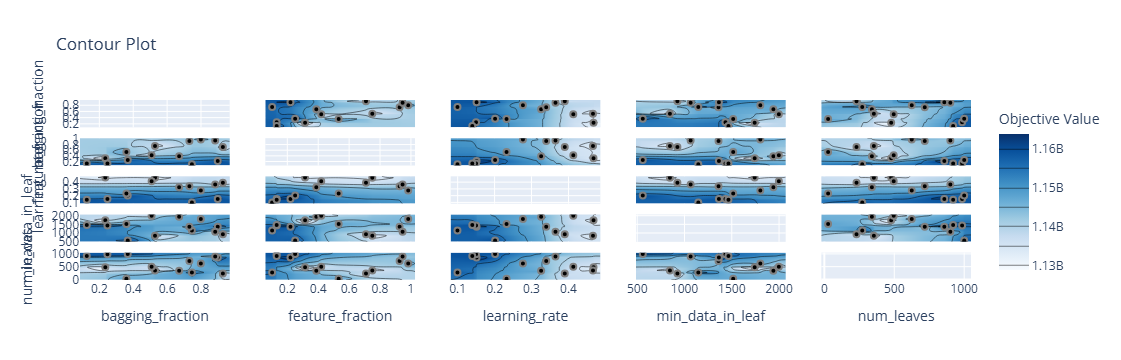

In [53]:
plot_contour(study)

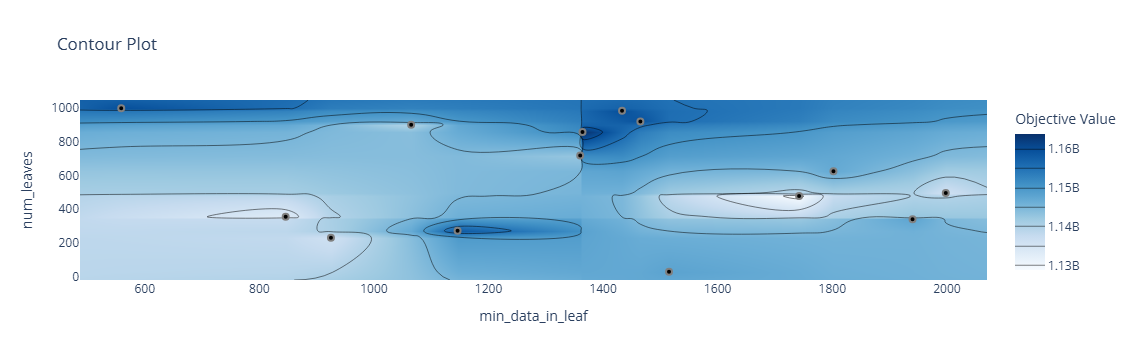

In [54]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

###  Best iter y División Train, validation (mes de validación 202406)
Defino las Best iteretion basado en Optuna. Luego divido el Train balanceado en Train y Validación para analizar las métricas.

In [ ]:
from sklearn.model_selection import train_test_split

best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}



### Hacemos un train validation usando 202106 como Validation month

In [114]:
train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)



X_train = train_data_balanced.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria2 = train_data_balanced['clase_binaria2']
w_train = train_data_balanced['clase_peso']





# Separar el conjunto de validación basado en un mes específico
X_val_month = X_train[X_train['foto_mes'] == 202106]
y_val_month = train_data_balanced[train_data_balanced['foto_mes'] == 202106]['clase_binaria2'].values
w_val_month = train_data_balanced[train_data_balanced['foto_mes'] == 202106]['clase_peso'].values

# El conjunto de entrenamiento será el resto de los datos

X_train_month = X_train[X_train['foto_mes'] != 202106]
y_train_month = train_data_balanced[train_data_balanced['foto_mes'] != 202106]['clase_binaria2'].values
w_train_month = train_data_balanced[train_data_balanced['foto_mes'] != 202106]['clase_peso'].values

# Crear datasets de LightGBM
train_data_month = lgb.Dataset(X_train_month, label=y_train_month, weight=w_train_month)
val_data_month = lgb.Dataset(X_val_month, label=y_val_month, weight=w_val_month, reference=train_data_month)

# Entrenar el modelo con validación
model_month = lgb.train(
    params,
    train_data,
    num_boost_round=best_iter,
    valid_sets=[train_data_month, val_data_month],
    valid_names=['train', 'valid'],
    feval=lgb_gan_eval
)


Observamos la variables más importantes para el modelo:

importances = model.feature_importance()
used_features = model.feature_name()  # Obtiene las características usadas realmente
importance_df = pd.DataFrame({'feature': used_features, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df = importance_df[importance_df['importance'] > 0]
print(importance_df)



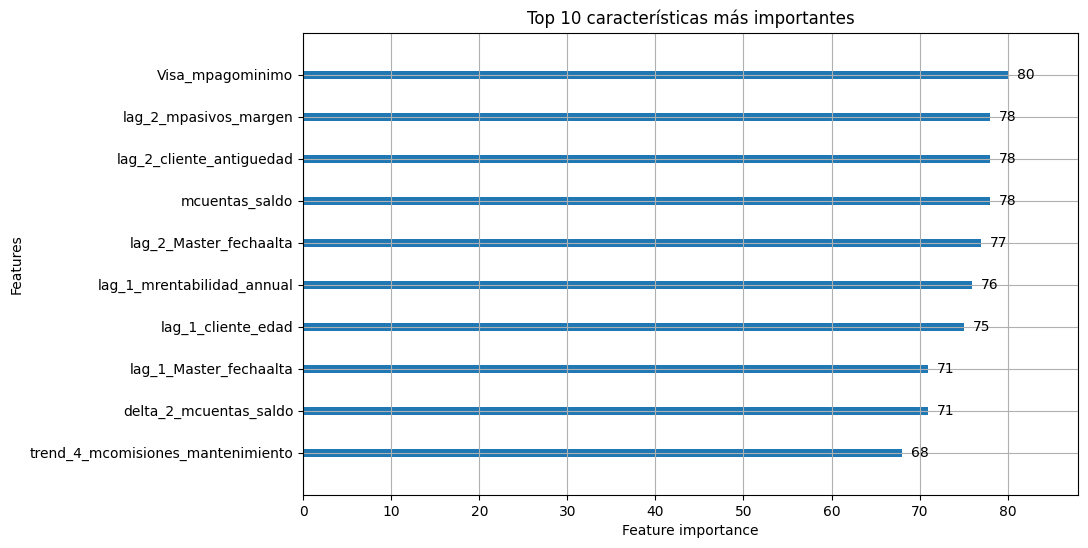

In [87]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# Graficar solo las 10 características más importantes
lgb.plot_importance(model, figsize=(10, 6), max_num_features=10)
plt.title("Top 10 características más importantes")
plt.show()


In [89]:
from sklearn.metrics import recall_score, precision_score

# Predicciones en el conjunto de validación y entrenamiento
y_pred_val = (model.predict(X_val_month) > 0.2).astype(int)  # Umbral de 0.5
y_pred_train = (model.predict(X_train_month) > 0.2).astype(int)

# Recall y Precision en el conjunto de validación
recall_val = recall_score(y_val_month, y_pred_val)
precision_val = precision_score(y_val_month, y_pred_val)

# Recall y Precision en el conjunto de entrenamiento
recall_train = recall_score(y_train_month, y_pred_train)
precision_train = precision_score(y_train_month, y_pred_train)

print("Recall (Validación):", recall_val)
print("Precision (Validación):", precision_val)
print("Recall (Entrenamiento):", recall_train)
print("Precision (Entrenamiento):", precision_train)

Recall (Validación): 0.850151362260343
Precision (Validación): 0.5481457384515289
Recall (Entrenamiento): 0.8597008637033916
Precision (Entrenamiento): 0.5621599283697224


Para guardar el modelo para poder utilizarlo más adelante, no es necesario guardarlo como *pickle*, la librería nos permite guardarlo en formato texto

### Probamos una nueva división entre train y validation con Cross validation

In [23]:
X_full = X_train
y_full = y_train_binaria2
w_full = w_train

In [104]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score, roc_curve, auc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de cross-validation
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Almacenar métricas y resultados para la curva ROC
recall_scores_cv = []
precision_scores_cv = []
y_val_all = []
y_prob_all = []

# Validación cruzada manual
for train_idx, val_idx in kf.split(X_full, y_full):
    # Dividir en entrenamiento y validación
    X_train_cv = X_full.iloc[train_idx]
    y_train_cv = y_full.iloc[train_idx]
    w_train_cv = w_full.iloc[train_idx]

    X_val_cv = X_full.iloc[val_idx]
    y_val_cv = y_full.iloc[val_idx]
    w_val_cv = w_full.iloc[val_idx]

    # Crear datasets de LightGBM
    train_data_cv = lgb.Dataset(X_train_cv, label=y_train_cv, weight=w_train_cv)
    val_data_cv = lgb.Dataset(X_val_cv, label=y_val_cv, weight=w_val_cv)

    # Entrenar modelo
    model_cv = lgb.train(
        params,
        train_data_cv,
        num_boost_round=best_iter,
        valid_sets=[train_data_cv, val_data_cv],
        valid_names=['train', 'valid'],
        feval=lgb_gan_eval,
    )

    # Obtener probabilidades para el conjunto de validación
    y_prob_cv = model_cv.predict(X_val_cv, num_iteration=model_cv.best_iteration)

    # Almacenar los valores reales y las probabilidades
    y_val_all.extend(y_val_cv)
    y_prob_all.extend(y_prob_cv)

    # Predicciones binarias con umbral por defecto (0.5)
    y_pred_cv = (y_prob_cv > 0.5).astype(int)

    # Calcular Recall y Precision
    recall_cv = recall_score(y_val_cv, y_pred_cv)
    precision_cv = precision_score(y_val_cv, y_pred_cv)

    # Guardar métricas por fold
    recall_scores_cv.append(recall_cv)
    precision_scores_cv.append(precision_cv)

# Promedio de métricas en cross-validation
mean_recall_cv = np.mean(recall_scores_cv)
mean_precision_cv = np.mean(precision_scores_cv)

print(f"Recall promedio en cross-validation: {mean_recall_cv:.4f}")
print(f"Precision promedio en cross-validation: {mean_precision_cv:.4f}")




Recall promedio en cross-validation: 0.3440
Precision promedio en cross-validation: 0.7371


In [105]:
# Métricas del modelo con el mes 202106 separado
y_pred_val_month = (model.predict(X_val_month, num_iteration=model.best_iteration) > 0.3
                   ).astype(int)

recall_val_month = recall_score(y_val_month, y_pred_val_month)
precision_val_month = precision_score(y_val_month, y_pred_val_month)

print(f"Recall en validación por mes: {recall_val_month:.4f}")
print(f"Precision en validación por mes: {precision_val_month:.4f}")


Recall en validación por mes: 0.7185
Precision en validación por mes: 0.6485


In [109]:
import pandas as pd

# Métricas del training con cross-validation
metrics_cross_val = {
    "Recall Promedio": mean_recall_cv,
    "Precision Promedio": mean_precision_cv
}

# Métricas del training con el mes separado
metrics_month_separated = {
    "Recall Promedio": recall_val_month,
    "Precision Promedio": precision_val_month
}

# Crear un DataFrame comparativo
comparison_df = pd.DataFrame({
    "Cross-Validation": metrics_cross_val,
    "Mes Separado (202106)": metrics_month_separated
})

# Mostrar el DataFrame
print(comparison_df)


                    Cross-Validation  Mes Separado (202106)
Recall Promedio             0.344023               0.718466
Precision Promedio          0.737069               0.648452


In [107]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score

# Define un rango de thresholds
thresholds = np.linspace(0.1, 0.9, 9)

# Resultados para cross-validation y mes separado
metrics_cross_val = []
metrics_month_separated = []

# Calcular métricas para cada threshold
for threshold in thresholds:
    # Predicciones binarias para cross-validation (simulando)
    y_pred_cross_val = (model.predict(X_val_month, num_iteration=model.best_iteration) > threshold).astype(int)
    recall_cv = recall_score(y_val_month, y_pred_cross_val)
    precision_cv = precision_score(y_val_month, y_pred_cross_val)
    f1_cv = f1_score(y_val_month, y_pred_cross_val)

    metrics_cross_val.append({"Threshold": threshold, "Recall": recall_cv, "Precision": precision_cv, "F1": f1_cv})

    # Predicciones binarias para el mes separado
    y_pred_month = (model.predict(X_val_month, num_iteration=model.best_iteration) > threshold).astype(int)
    recall_month = recall_score(y_val_month, y_pred_month)
    precision_month = precision_score(y_val_month, y_pred_month)
    f1_month = f1_score(y_val_month, y_pred_month)

    metrics_month_separated.append({"Threshold": threshold, "Recall": recall_month, "Precision": precision_month, "F1": f1_month})

# Convertir a DataFrames
df_cross_val = pd.DataFrame(metrics_cross_val)
df_month_separated = pd.DataFrame(metrics_month_separated)

# Combinar ambas tablas para comparar
comparison_df = pd.concat([df_cross_val, df_month_separated], axis=1, keys=["Cross-Validation", "Mes Separado (202106)"])

comparison_df


Cross-Validation                               Mes Separado (202106)  \
         Threshold    Recall Precision        F1             Threshold   
0              0.1  0.957114  0.406210  0.570355                   0.1   
1              0.2  0.850151  0.548146  0.666535                   0.2   
2              0.3  0.718466  0.648452  0.681666                   0.3   
3              0.4  0.576186  0.725540  0.642295                   0.4   
4              0.5  0.438951  0.770593  0.559306                   0.5   
5              0.6  0.285066  0.780387  0.417591                   0.6   
6              0.7  0.169021  0.829208  0.280805                   0.7   
7              0.8  0.086276  0.859296  0.156809                   0.8   
8              0.9  0.024218  0.888889  0.047151                   0.9   

                                 
     Recall Precision        F1  
0  0.957114  0.406210  0.570355  
1  0.850151  0.548146  0.666535  
2  0.718466  0.648452  0.681666  
3  0.576186  0.725540  0.642295  
4  0.438951  0.770593  0.559306  
5  0.285066  0.780387  0.417591  
6  0.169021  0.829208  0.280805  
7  0.086276  0.859296  0.156809  
8  0.024218  0.888889  0.047151

In [70]:
model_cv.save_model(modelos_path + 'lgb_second9.txt')

Y recuperar el mismo desde ese formato

In [73]:
model = lgb.Booster(model_file=modelos_path + 'lgb_second9.txt')

Para realizar nuestra habitual comparación de modelos, partiremos desde el mejor que obtuvimos hasta ahora, el **rf**. Para este fin cargaremos el *binario* que ajustamos un par de clases atrás:

Y sobre ambos modelos obtenemos la predicción de **Septiembre**

### Predicción de X_test

In [ ]:
from sklearn.metrics import precision_recall_curve

# Calcular las probabilidades para el conjunto de prueba
y_test_prob = model.predict(X_test)


# Convertir probabilidades en predicciones binarias
threshold = 0.3  # Puedes ajustar este umbral si es necesario
y_test_pred = (y_test_prob >= threshold).astype(int)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calcular métricas
accuracy = accuracy_score(y_test_binaria1, y_test_pred)
precision = precision_score(y_test_binaria1, y_test_pred)
recall = recall_score(y_test_binaria1, y_test_pred)
f1 = f1_score(y_test_binaria1, y_test_pred)

# Imprimir métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_binaria1, y_test_pred)

# Etiquetas de las clases (puedes personalizarlas según corresponda)
class_labels = ["Clase Negativa", "Clase Positiva"]

# Mostrar la matriz de confusión con etiquetas
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap="Blues", values_format="d")  # `values_format="d"` muestra valores enteros
plt.title("Matriz de Confusión")
plt.show()



Accuracy: 0.9347458840372226
Precision: 0.27521679598356913
Recall: 0.4659969088098918
F1 Score: 0.3460545193687231


In [40]:
# Crear un DataFrame con las columnas seleccionadas
filtered_results_df = X_test[['numero_de_cliente', 'foto_mes']].copy()

# Agregar las columnas de resultados
filtered_results_df['y_test_prob'] = y_test_prob
filtered_results_df['y_test_pred'] = y_test_pred
filtered_results_df['y_test_real'] = y_test_binaria1.values

# Aplicar filtro para dejar solo los y_test_real = 1
filtered_results_df = filtered_results_df[filtered_results_df['y_test_real'] == 0]

# Mostrar las primeras filas del DataFrame
filtered_results_df




,numero_de_cliente,foto_mes,y_test_prob,y_test_pred,y_test_real
0,946449350,202107,0.001290,0,0
1,549625262,202107,0.000199,0,0
3,336314255,202107,0.568580,1,0
4,571072377,202107,0.002347,0,0
5,872241468,202107,0.033334,0,0
...,...,...,...,...,...
34920,848749393,202107,0.093030,1,0
34921,1075880661,202107,0.005419,0,0
34922,1038952511,202107,0.001309,0,0
34923,950661761,202107,0.006911,0,0


In [47]:
filtered_results_df.y_test_pred.value_counts()

y_test_pred
0    27959
1     5672
Name: count, dtype: int64

### Predicción Objetivo

In [170]:
from sklearn.metrics import precision_recall_curve

# Realizar predicciones para 202109
# y_Septiembre_prob = model.predict(Septiembre_pre)


# Convertir probabilidades en predicciones binarias
threshold = 0.021  # Puedes ajustar este umbral si es necesario (Threshold optimo 0.47)
y_Septiembre_pred = (y_Septiembre_prob >= threshold).astype(int)






In [171]:
Septiembre_pre['Prediction'] = y_Septiembre_pred


# Filtrar el DataFrame para quedarte solo con 'numero_de_cliente' y 'prediccion'
result_septiembre = Septiembre_pre[['numero_de_cliente', 'Prediction']]

# Renombrar la columna 'prediccion' a 'Predicted' si es necesario
result_septiembre.rename(columns={'Prediction': 'Predicted'}, inplace=True)

# Ver las primeras filas del DataFrame resultante
result_septiembre


/tmp/ipykernel_2083/1169103488.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,numero_de_cliente,Predicted
8,249221109,0
17,249221468,0
26,249223005,0
43,249232117,0
52,249236712,0
...,...,...
1478179,1606470344,0
1478180,1606478730,0
1478181,1606600592,0
1478182,1606610942,1


In [172]:
grouped_counts = result_septiembre.groupby('Predicted').size()
print("Conteo agrupado por predicción:")
print(grouped_counts)


Conteo agrupado por predicción:
Predicted
0    155439
1     10205
dtype: int64


In [173]:
# Especificar la ruta completa del archivo donde deseas guardar el DataFrame
output_file = dataset_path + "predicciones_Septiembre5.csv"

# Guardar el DataFrame como un archivo CSV en la ruta 
result_septiembre.to_csv('predicciones_septiembre5.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt

plt.hist(predict_data['probabilidad'], bins=50, alpha=0.7, color='blue')
plt.title("Distribución de probabilidades predichas")
plt.xlabel("Probabilidad")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
import seaborn as sns

for column in X_train.columns[:5]:  # Analiza las primeras 5 características
    plt.figure(figsize=(8, 4))
    sns.kdeplot(train_data[column], label="Train", shade=True)
    sns.kdeplot(predict_data[column], label="Predict", shade=True)
    plt.title(f"Distribución de {column}")
    plt.legend()
    plt.show()
